In [1]:
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
"""!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /home/soundarzozm/Desktop/mask_detector/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"""
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/home/soundarzozm/Desktop/mask_detector/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [2]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/soundarzozm/Desktop/mask_detector'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_mask_dir = os.path.join(train_dir, 'with_mask')
train_no_mask_dir = os.path.join(train_dir, 'without_mask')
validation_mask_dir = os.path.join(validation_dir, 'with_mask')
validation_no_mask_dir = os.path.join(validation_dir, 'without_mask')

train_mask_fnames = os.listdir(train_mask_dir)
train_no_mask_fnames = os.listdir(train_no_mask_dir)

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (256, 256))     

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size  = 20,
                                                         class_mode  = 'binary',
                                                         target_size = (256, 256))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size = 1,
                                                  shuffle=False,
                                                  class_mode='binary',
                                                  target_size = (256, 256))

Found 1314 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [4]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 4,
            validation_steps = 50,
            verbose = 1)

Epoch 1/4
100/100 [==============================] - 380s 4s/step - loss: 0.2875 - accuracy: 0.9353 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/4
100/100 [==============================] - 365s 4s/step - loss: 0.0764 - accuracy: 0.9764 - val_loss: 1.5208e-04 - val_accuracy: 1.0000
Epoch 3/4
100/100 [==============================] - 353s 4s/step - loss: 0.0379 - accuracy: 0.9875 - val_loss: 0.0171 - val_accuracy: 0.9920
Epoch 4/4
100/100 [==============================] - 361s 4s/step - loss: 0.0359 - accuracy: 0.9879 - val_loss: 5.6364e-05 - val_accuracy: 1.0000


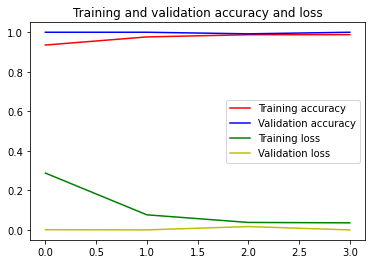

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [6]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict(test_generator, steps = nb_samples)

In [7]:
model.save("model.h5")

In [ ]:
print(predict)